## My goal is to understand the relationship between the target variable (Churn) and the features in the dataset and make recommendations to improve customer retention.

In [197]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import chi2 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import seaborn as sns 
import matplotlib.pyplot as plt


In [57]:
# import data 
data = pd.read_csv("/Users/mario.iuliano/marios_env/Portfolio/test/feature_selection/churn/telco.csv")

In [58]:
# Data shape
data.shape

(7043, 21)

In [59]:
# data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [60]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [61]:
# standardise column names 
data.columns = data.columns.str.lower().str.replace(' ', '')

In [62]:
# drop customerid 
data.drop(columns= ['customerid'], inplace=True)

In [63]:
# dropping total charges as it is computed tenure * monthly charges
data.drop(columns= ['totalcharges'], inplace=True)

In [64]:
# convert target variable to binary
data['churn'] = data['churn'].map({'Yes': 1, 'No': 0})

In [65]:
# explore distributions 
data.describe()

,seniorcitizen,tenure,monthlycharges,churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


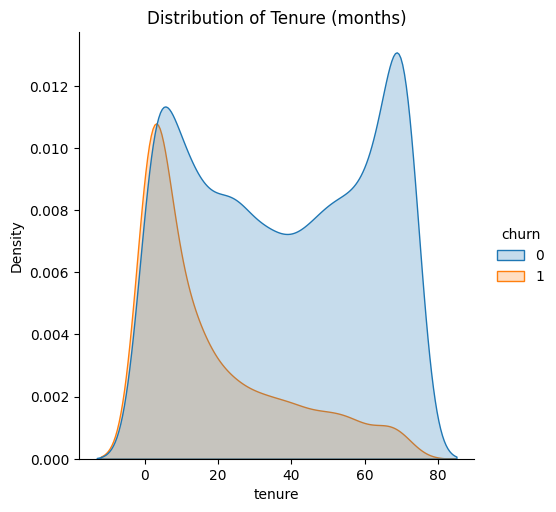

In [70]:
# there is much varaiance in teneure and monthly charges
import seaborn as sns 

sns.displot(data = data, x = 'tenure', hue = 'churn',  kind = 'kde', fill = True)
plt.title('Distribution of Tenure (months)')
plt.show()

In [ ]:
# Lower tenure is associated with churn. This means that investing on customer retention in the first months of the contract is important.

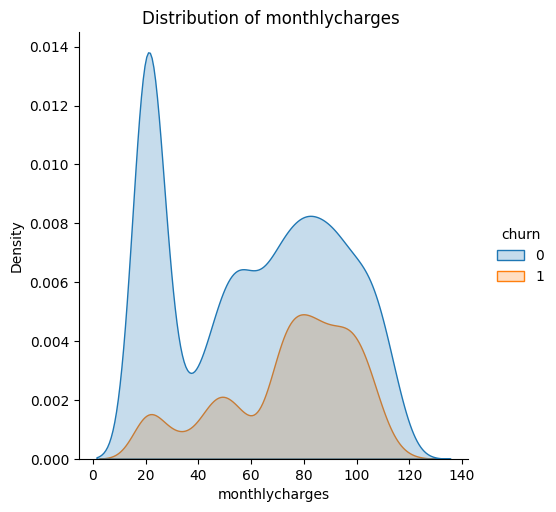

In [73]:
sns.displot(data = data, x = 'monthlycharges', hue = 'churn',  kind = 'kde', fill = True)
plt.title('Distribution of monthlycharges ')
plt.show()

In [ ]:
# highh monthly charges are also asscociated with churn

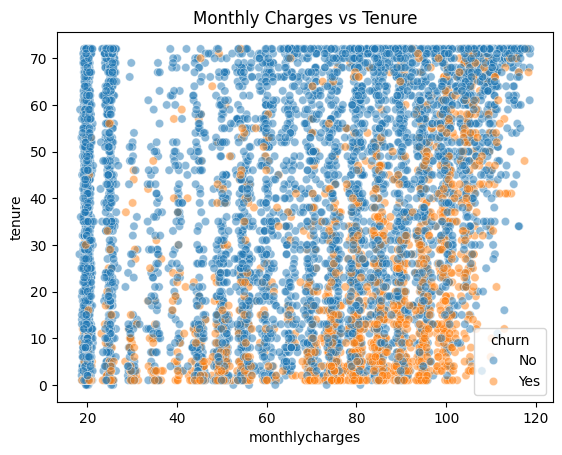

In [35]:
sns.scatterplot(data = data, y = 'tenure', x = 'monthlycharges', hue = 'churn', alpha = 0.5)
plt.title('Monthly Charges vs Tenure')
plt.show()

In [ ]:
# Higher monthly charges in the first months are a redflag for churn. Although, the relationship is not linear and hihg monthly charges with higher tenure also leed to churns
# Understand the relationship with churn applying logistic regression

In [77]:
data[['tenure', 'monthlycharges']].corr()

,tenure,monthlycharges
tenure,1.0000,0.2479
monthlycharges,0.2479,1.0000


In [78]:
# 1 Scale monthly charges and tenure
# Train log reg 
# output the coefficients

In [79]:
scaler = StandardScaler()
X_scaled= scaler.fit_transform(data[['tenure', 'monthlycharges']])
lr = LogisticRegression()
lr.fit(X_scaled, data['churn'])

LogisticRegression()

In [89]:
coeff = lr.coef_[0]
odds_ration = np.exp(coeff)
odds_ratio_df = pd.DataFrame({
    'features': ['tenure', 'monthlycharges'],
    'coefficients': coeff,
    'odds_ratio': odds_ration
})

In [90]:
odds_ratio_df

,features,coefficients,odds_ratio
0,tenure,-1.343807,0.260851
1,monthlycharges,0.988897,2.688267


In [92]:
# Higher tenure is associated with lower odds of churn, while higher monthly charges are associated with higher odds of churn.

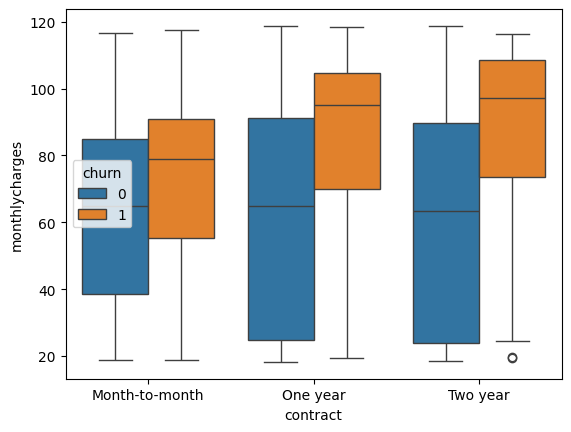

In [99]:
# Let's understand why low tenure is associtaed with high monthly charges
# Let's start from contract 

sns.boxplot(data = data,  x= 'contract', y = 'monthlycharges', hue = 'churn')
plt.show()

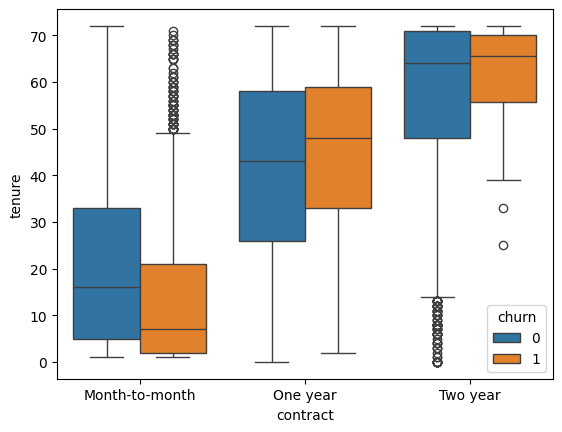

In [100]:
# how about tenure 
sns.boxplot(data = data,  x= 'contract', y = 'tenure', hue = 'churn')
plt.show()

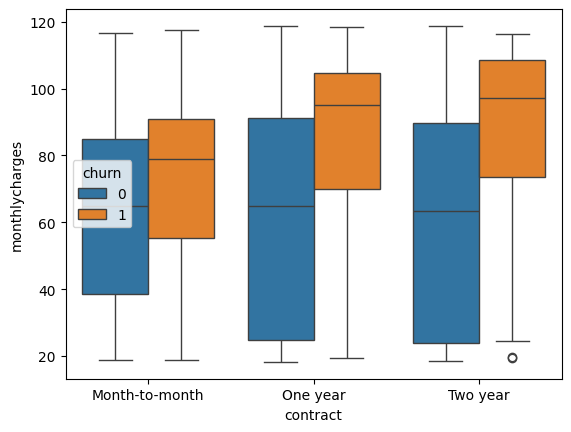

In [190]:
# how about tenure 
sns.boxplot(data = data,  x= 'contract', y = 'monthlycharges', hue = 'churn')
plt.show()

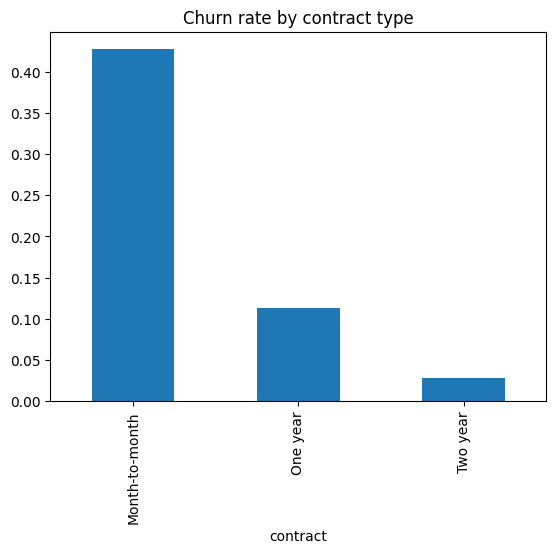

In [106]:
# Because the month to month contract are associated with general lower tenure we could assume that these are new customers.
# As month to month is also associated with retention, we could assume that churners are affected by wrong pricing and plan strategy

# What is the percentage of churners in Month-to-Month contracts?
data.groupby('contract').churn.mean().plot(kind = 'bar')
plt.title('Churn rate by contract type')
plt.show()

In [ ]:
# 42% of the churners have a month to month contract. Focusing on this group could be a good strategy to reduce churn.


In [147]:
groupped = data.groupby(['contract', 'seniorcitizen']).churn.sum().reset_index()

In [148]:
groupped['churn_rate'] = groupped.churn/groupped.groupby('contract').churn.transform('sum')


In [149]:
groupped.sort_values(by = ['contract', 'churn_rate'], ascending = False, inplace = True)

In [188]:
# Analyse churn rates by all categorical variables
categorical = data.select_dtypes(include = ['object']).columns.tolist()
categorical.append('seniorcitizen')

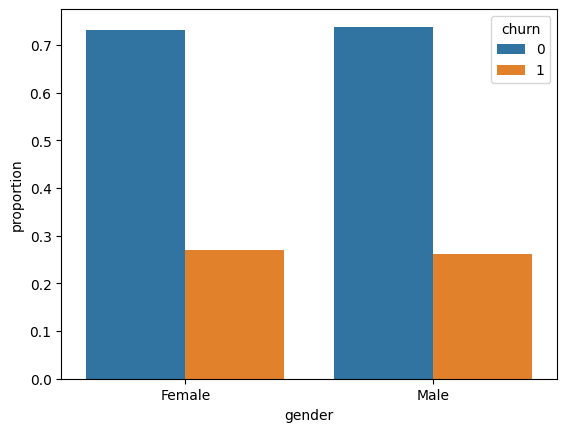

   gender  churn  count  proportion
0  Female      0   2549    0.730791
1  Female      1    939    0.269209
2    Male      0   2625    0.738397
3    Male      1    930    0.261603


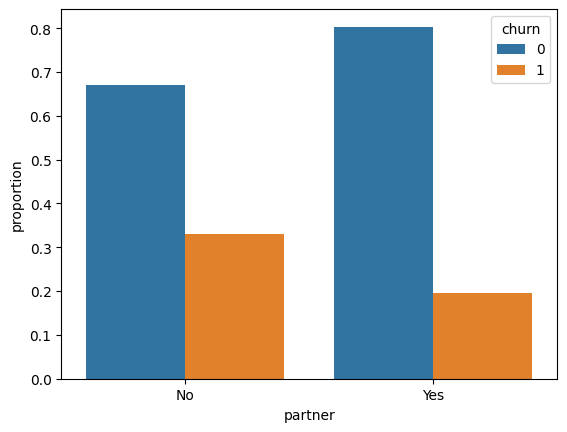

  partner  churn  count  proportion
0      No      0   2441    0.670420
1      No      1   1200    0.329580
2     Yes      0   2733    0.803351
3     Yes      1    669    0.196649


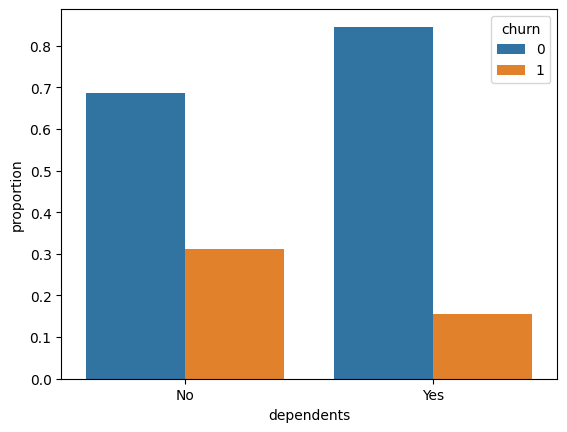

  dependents  churn  count  proportion
0         No      0   3390    0.687209
1         No      1   1543    0.312791
2        Yes      0   1784    0.845498
3        Yes      1    326    0.154502


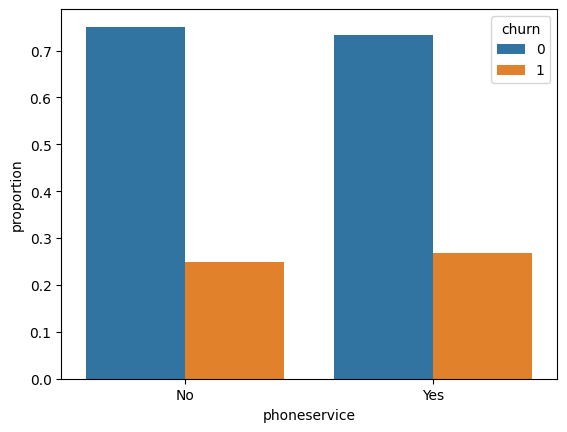

  phoneservice  churn  count  proportion
0           No      0    512    0.750733
1           No      1    170    0.249267
2          Yes      0   4662    0.732904
3          Yes      1   1699    0.267096


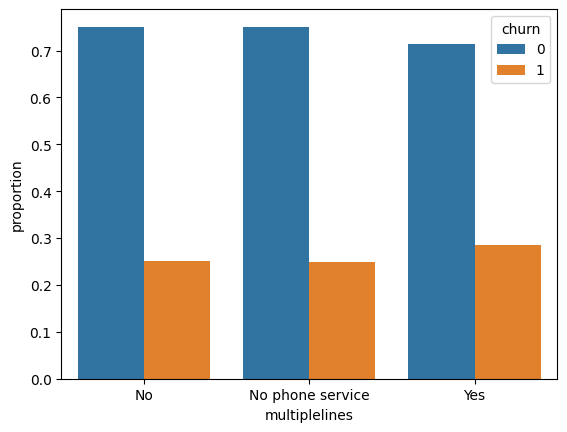

      multiplelines  churn  count  proportion
0                No      0   2541    0.749558
1                No      1    849    0.250442
2  No phone service      0    512    0.750733
3  No phone service      1    170    0.249267
4               Yes      0   2121    0.713901
5               Yes      1    850    0.286099


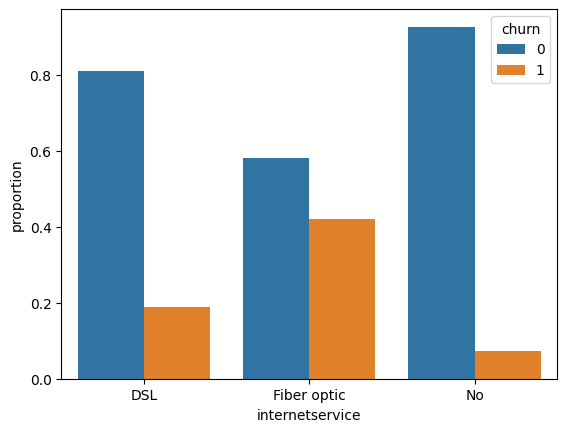

  internetservice  churn  count  proportion
0             DSL      0   1962    0.810409
1             DSL      1    459    0.189591
2     Fiber optic      0   1799    0.581072
3     Fiber optic      1   1297    0.418928
4              No      0   1413    0.925950
5              No      1    113    0.074050


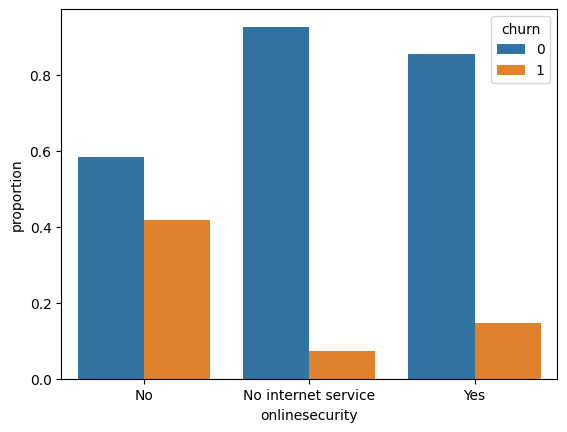

        onlinesecurity  churn  count  proportion
0                   No      0   2037    0.582333
1                   No      1   1461    0.417667
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1724    0.853888
5                  Yes      1    295    0.146112


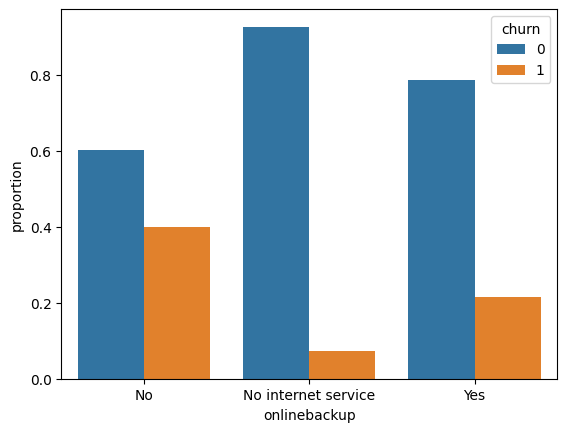

          onlinebackup  churn  count  proportion
0                   No      0   1855    0.600712
1                   No      1   1233    0.399288
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1906    0.784685
5                  Yes      1    523    0.215315


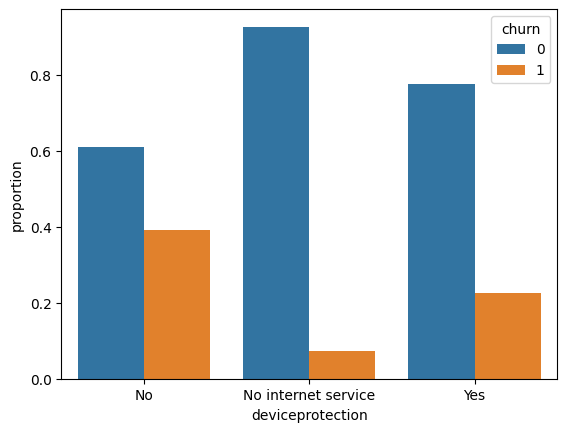

      deviceprotection  churn  count  proportion
0                   No      0   1884    0.608724
1                   No      1   1211    0.391276
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1877    0.774979
5                  Yes      1    545    0.225021


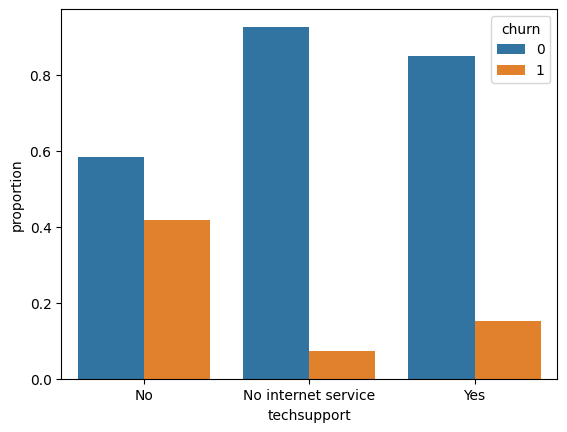

           techsupport  churn  count  proportion
0                   No      0   2027    0.583645
1                   No      1   1446    0.416355
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1734    0.848337
5                  Yes      1    310    0.151663


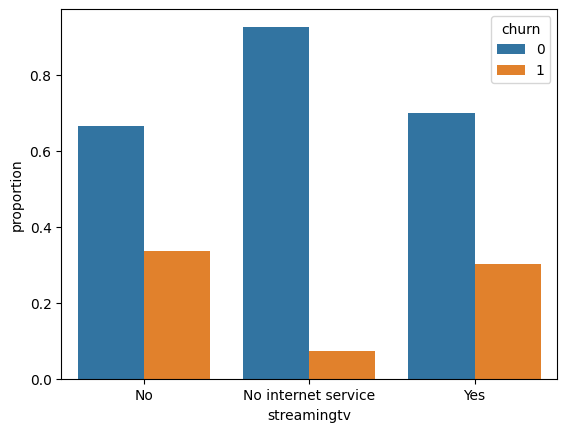

           streamingtv  churn  count  proportion
0                   No      0   1868    0.664769
1                   No      1    942    0.335231
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1893    0.699298
5                  Yes      1    814    0.300702


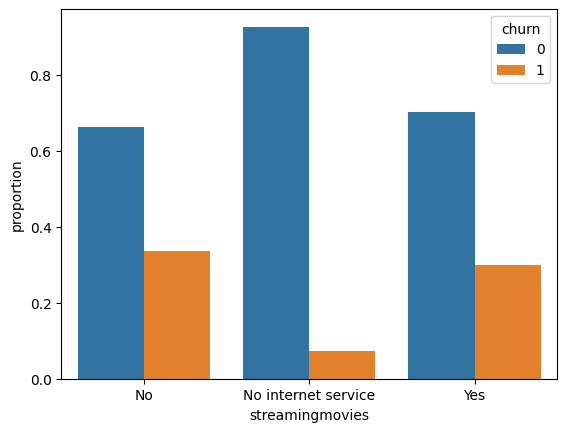

       streamingmovies  churn  count  proportion
0                   No      0   1847    0.663196
1                   No      1    938    0.336804
2  No internet service      0   1413    0.925950
3  No internet service      1    113    0.074050
4                  Yes      0   1914    0.700586
5                  Yes      1    818    0.299414


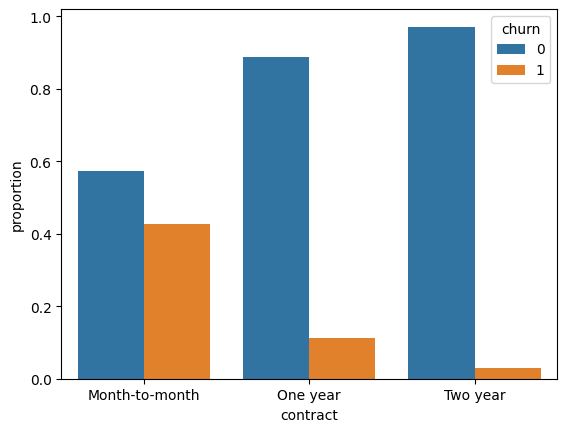

         contract  churn  count  proportion
0  Month-to-month      0   2220    0.572903
1  Month-to-month      1   1655    0.427097
2        One year      0   1307    0.887305
3        One year      1    166    0.112695
4        Two year      0   1647    0.971681
5        Two year      1     48    0.028319


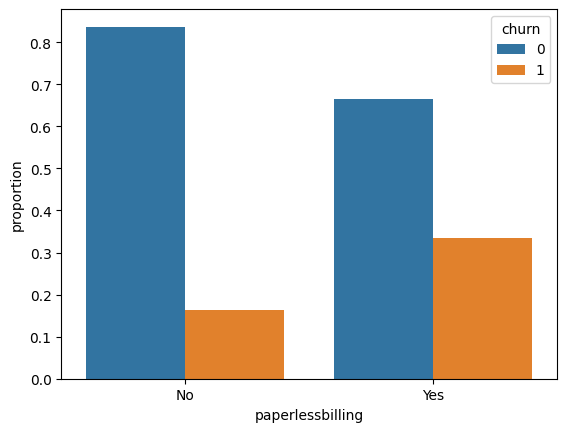

  paperlessbilling  churn  count  proportion
0               No      0   2403    0.836699
1               No      1    469    0.163301
2              Yes      0   2771    0.664349
3              Yes      1   1400    0.335651


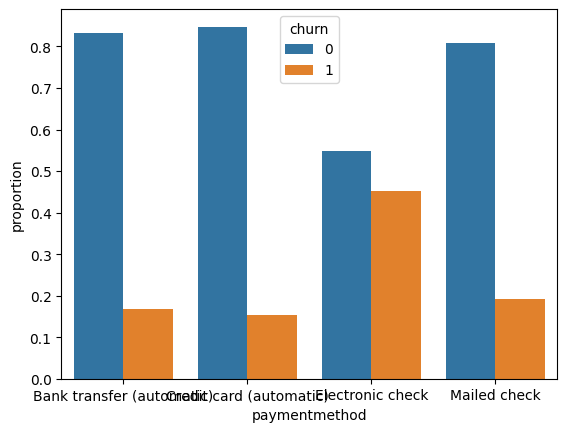

               paymentmethod  churn  count  proportion
0  Bank transfer (automatic)      0   1286    0.832902
1  Bank transfer (automatic)      1    258    0.167098
2    Credit card (automatic)      0   1290    0.847569
3    Credit card (automatic)      1    232    0.152431
4           Electronic check      0   1294    0.547146
5           Electronic check      1   1071    0.452854
6               Mailed check      0   1304    0.808933
7               Mailed check      1    308    0.191067


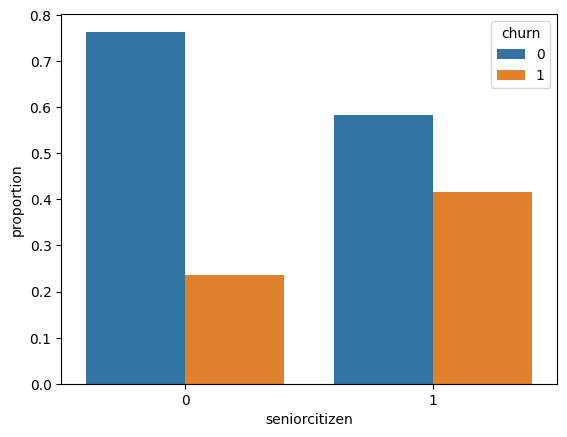

   seniorcitizen  churn  count  proportion
0              0      0   4508    0.763938
1              0      1   1393    0.236062
2              1      0    666    0.583187
3              1      1    476    0.416813


In [189]:
for col in categorical:
    ax = data.groupby(col).churn.value_counts(normalize = True).reset_index()
    sns.barplot(data= ax, x= col, y = 'proportion', hue = 'churn')
    plt.show()
    counts = data.groupby(col).churn.value_counts().reset_index()
    rates = data.groupby(col).churn.value_counts(normalize = True).reset_index()
    ax = pd.merge(counts, rates, on = [col, 'churn'], suffixes = ('_count', '_rate'))
    print(ax)

In [194]:
data.groupby('contract').seniorcitizen.value_counts(normalize = True).reset_index()

,contract,seniorcitizen,proportion
0,Month-to-month,0,0.791742
1,Month-to-month,1,0.208258
2,One year,0,0.871012
3,One year,1,0.128988
4,Two year,0,0.914454
5,Two year,1,0.085546


In [ ]:
# Senior citizens are more likely to have a month to month contract. This is a red flag for churn.

In [ ]:
# Feature selection 
# 1 Convert categorical variables to numerical
# 2 Apply chi2 test to find the most important features


In [ ]:
categorical = data.select_dtypes(include = ['object'])
le_df = data.copy()
le = LabelEncoder()

for col in categorical.columns: 
    le_df[col] = le.fit_transform(le_df[col])

chi2_stats, p_valus = chi2(le_df[categorical.columns], le_df['churn'])

In [212]:
pd.DataFrame(
    {'features':categorical.columns,
     'chi2_stats': chi2_stats,
     'p_values': p_valus}
).sort_values(by = 'p_values', ascending = True)

,features,chi2_stats,p_values
12,contract,1115.780167,1.227941e-244
6,onlinesecurity,551.611529,5.615882e-122
9,techsupport,523.303866,8.086236e-116
7,onlinebackup,230.086520,5.707869e-52
8,deviceprotection,191.303140,1.651539e-43
2,dependents,133.036443,8.876729e-31
13,paperlessbilling,105.680863,8.661987e-25
1,partner,82.412083,1.104764e-19
14,paymentmethod,58.492250,2.040933e-14
5,internetservice,9.821028,1.725279e-03


In [205]:
df_encoded

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,1
